In [1]:
# from bao import *
from static import *
from stock_data import *
from efficient_frontier import *
from icecream import ic

with open(PATH_DICTIONARY, "r") as a:
    name_dict = json.load(a)

* **I would like to build 10 portfolios that with specific return and give back portfolio allocation with best variance**
* **Then testing stategy that following best variance through out the posible time**
* **Time for train is 1 year and result applying is also 1 year**

In [2]:
stock = StockData("./data/stock/", "./stock_dictionary.json")
stock_data = stock.get_data()
with open(PATH_INDEX, "r") as a:
    index_l = json.load(a)
stock_data.drop(columns=["symbol"], inplace=True)
df = stock_data[
    (stock_data["market_value"] > 0)
    & (stock_data["time"].dt.year == 2024) 
    & (stock_data["ticker"].str.len() == 3)
    & (stock_data["ticker"].isin(index_l["VN30"]))
]

In [3]:
# makes sure to only use stocks that have market value > 0
weights = df.pivot_table(index="time", values="market_value", columns="ticker")
weights.dropna(axis=1, inplace=True)
weights = weights.div(weights.sum(axis=0), axis=1)

returns_df = df[df["ticker"].isin(weights.columns)].pivot_table(
    index="time", values="log_return", columns="ticker"
)

In [5]:
results = tracking(stock_data, index_l["VN30"]).sort_values(["year", "train_return"])

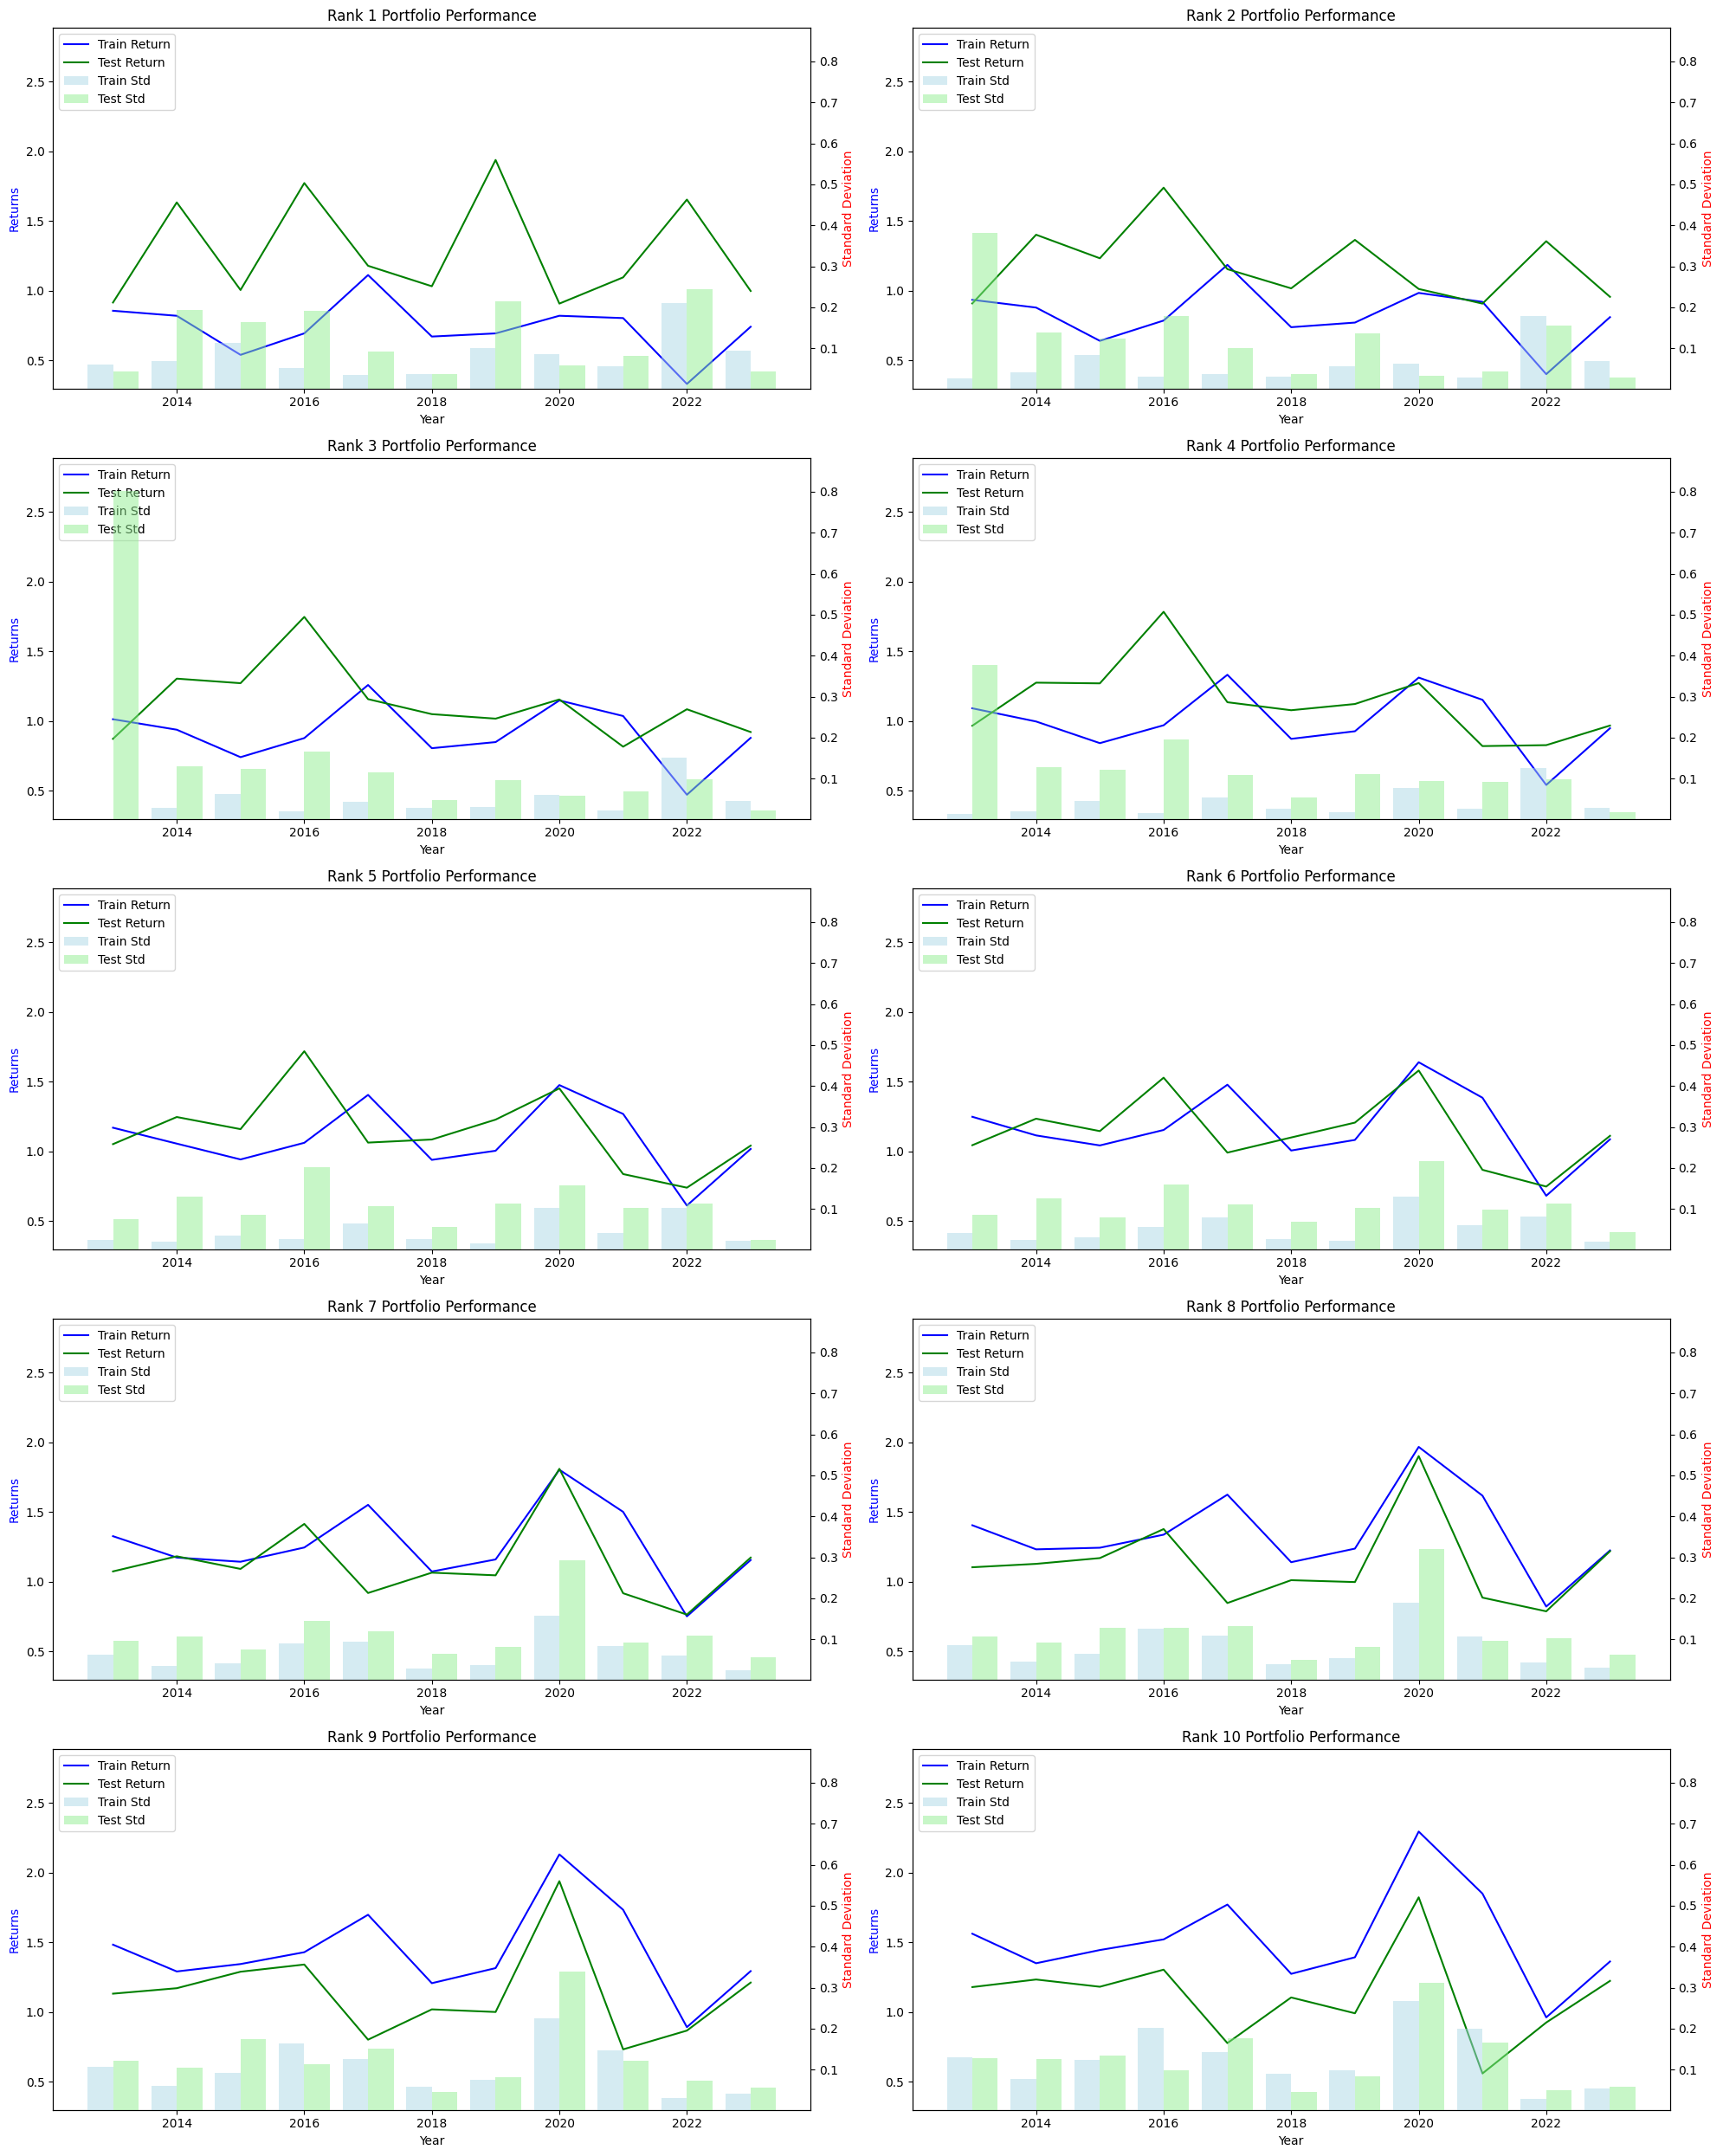

In [7]:
import matplotlib.pyplot as plt

# Create a figure with subplots
fig = plt.figure(figsize=(20, 25))

# Sort results by train_return and add rank column
results = results.sort_values(["year", "train_return"])
results["rank"] = results.groupby("year").cumcount() + 1

# First calculate the overall min and max values for consistent scaling
y1_min = min(results["train_return"].min(), results["test_return"].min())
y1_max = max(results["train_return"].max(), results["test_return"].max())
y2_min = min(results["train_std"].min(), results["test_std"].min())
y2_max = max(results["train_std"].max(), results["test_std"].max())

# Plot each rank in a separate subplot
for i in range(1, 11):
    mask = results["rank"] == i
    ax = plt.subplot(5, 2, i)

    # Plot returns as lines
    ax.plot(results[mask]["year"], results[mask]["train_return"], "b-", label="Train Return")
    ax.plot(results[mask]["year"], results[mask]["test_return"], "g-", label="Test Return")
    ax.set_ylim(y1_min * 0.9, y1_max * 1.1)  # Set consistent y-axis range for returns

    # Create second y-axis for standard deviations
    ax2 = ax.twinx()
    ax2.bar(
        results[mask]["year"] - 0.2,
        results[mask]["train_std"],
        0.4,
        color="lightblue",
        alpha=0.5,
        label="Train Std",
    )
    ax2.bar(
        results[mask]["year"] + 0.2,
        results[mask]["test_std"],
        0.4,
        color="lightgreen",
        alpha=0.5,
        label="Test Std",
    )
    ax2.set_ylim(y2_min * 0.9, y2_max * 1.1)  # Set consistent y-axis range for std

    # Set labels and title
    ax.set_xlabel("Year")
    ax.set_ylabel("Returns", color="b")
    ax2.set_ylabel("Standard Deviation", color="r")
    plt.title(f"Rank {i} Portfolio Performance")

    # Add legend
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.tight_layout()
plt.show()